In [45]:
# If running on Google Colab, run this cell first
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import sys
sys.path.append('/content/drive/My Drive/Lyapunov')

Mounted at /content/drive


In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import chainer

import pickle as pkl
import matplotlib
import math

from torch.autograd import Variable
from torch.nn import RNN, GRU, LSTM, Linear, Embedding
from tqdm import tqdm
from torch import nn
import torch
from keras.utils import to_categorical

import lyapunov as l
from importlib import reload  # Python 3.4+ only.
import gc
import sys
from math import floor
from importlib import reload
from matplotlib import cm
from matplotlib.lines import Line2D
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib

from random import random
from random import seed

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
import os.path as path

import dataloader as dl

Using TensorFlow backend.


In [0]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
# top_directory = 'drive/My Drive/Lyapunov/CharRNN/WP'
top_directory = 'CharRNN/WP'
class Config:
    def __init__(self, data_dir = top_directory, rnn_model = 'lstm', hidden_size = 128, num_layers = 1, dropout = 0.0, learning_rate = .002, embedded = 'one-hot',
                 seq_length = 100, batch_size= 100, max_epochs = 50, decay_rate = 0.95, decay_start = 10, train_frac = 0.8, val_frac = 0.1,
                 cuda = torch.cuda.is_available(), model_dir = top_directory + '/HP/Models',
                 print_interval = 100, optimizer = 'adam', init_type = 'uniform', init_param = 0.08):
        
        self.data_dir = data_dir 
        
        self.rnn_model = rnn_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedded = embedded
        self.init_type = init_type
        self.init_param = init_param
        
        self.learning_rate = learning_rate #initial learning rate
        self.optimizer = optimizer
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.decay_rate = decay_rate
        self.decay_start = decay_start
        self.train_frac = train_frac
        self.val_frac = val_frac
        
        self.cuda = cuda
        self.model_dir = model_dir
        self.full_name = "{}_L{}_H{}_drop{}_lr{}_{}_{}{}".format(self.rnn_model, self.num_layers, self.hidden_size, self.dropout, 
                                                                 self.learning_rate, self.optimizer, self.init_type, self.init_param)
#         self.full_name = "{}_L{}_H{}_drop{}_{}".format(self.rnn_model, self.num_layers, self.hidden_size, self.dropout, self.optimizer)

        self.print_interval = print_interval

## Data Preprocessing

In [4]:
#Need to have input.txt or vocab.pkl and data.pkl in the Configuration's data_dir folder
con = Config()
train_set, val_set, test_set, (char_to_int, int_to_char) = dl.create_dataset(con)
train_input_set, train_target_set = train_set[0], train_set[1]
val_input_set, val_target_set = val_set[0], val_set[1]
test_input_set, test_target_set = test_set[0], test_set[1] 
vocab_size = len(char_to_int)

Loading  CharRNN/WP\data.pkl ...
Loading  CharRNN/WP\vocab.pkl ...
None
Cutting off end of data so that it divides evenly
Data load done! Number of data batches in train: 256, val: 32, test: 31


## Create Model Template, Train and Validation functions

In [5]:
# build the model using the pytorch nn module
class CharRNN(nn.ModuleList):
    def __init__(self, num_layers, vocab_size, hidden_size, model = 'lstm', p_drop = 0.0, embedded = 'one-hot', dynamics = False, 
                 cuda = torch.cuda.is_available(), init_type = 'uniform', init_param = 0.08):
        super(CharRNN, self).__init__()
        
        # init the meta parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.model = model
        self.L = self.num_layers*self.hidden_size
        self.dynamics = dynamics
        self.embedded = embedded
        self.init_type = init_type
        self.init_param = init_param
        self.device = torch.device('cuda') if cuda else torch.device('cpu')
        
        if self.embedded == None:
            self.encoder = nn.Identity()
        elif self.embedded == 'embedding':
            self.encoder = Embedding(input_size, input_size)
        elif self.embedded == 'one-hot':
            self.encoder = lambda xt: torch.from_numpy(to_categorical(xt.cpu(), self.vocab_size)).to(self.device)
        else:
            raise Exception('Embedding type not defined')
            
            
        if model == 'rnn':
            self.rnn_layer = RNN(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = hidden_size
        elif model == 'gru':
            self.rnn_layer = GRU(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 3*hidden_size
        elif model == 'lstm':
            self.rnn_layer = LSTM(num_layers = self.num_layers, hidden_size=hidden_size, input_size=vocab_size, batch_first=True, bias = False)
            self.gate_size = 4*hidden_size
        else:
            raise Exception('Recurrent model not defined. Exitting.')

        #Initialize weights to all be between -0.08 and 0.08 (or defined initiazation)
        for layer_p in self.rnn_layer._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    # nn.init.uniform_(self.rnn_layer.__getattr__(p), -0.08, 0.08)
                    self.init_weights(p)


        self.dropout = nn.Dropout(p=p_drop)
        self.fc = Linear(in_features = hidden_size, out_features = vocab_size, bias = False)
        
    def forward(self, xt, h):
        encoded = self.encoder(xt)
        self.rnn_layer.flatten_parameters()
        rnn_out, rnn_hn = self.rnn_layer(encoded, h)
        d_out = self.dropout(rnn_out)
        output = self.fc(d_out)
        return output, rnn_hn
    
    def init_weights(self, p):
        init_options = ['uniform', 'normal', 'xavier']
        if self.init_type == 'uniform':
            nn.init.uniform_(self.rnn_layer.__getattr__(p), -self.init_param, self.init_param)
        elif self.init_type == 'normal':
            nn.init.normal_(self.rnn_layer.__getattr__(p), std = self.init_param)
        elif self.init_type == 'xavier':
            nn.init.xavier_normal_(self.rnn_layer.__getattr__(p), gain = self.init_param)
        else:
            print('{} is not a valid initialization type. Options are: {}'.format(self.init_type, init_options))

    def init_hidden(self, batch_size):
        if self.model == 'lstm':
            if self.dynamics:
                return (Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device))
            else:
                return (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device),
                    Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(self.device))

        if self.dynamics:
            return Variable(torch.randn(self.num_layers, batch_size, self.hidden_size)).to(device)
        else:
            return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)


In [0]:
def train_hp(train_set, val_set, vocab_size, config, init_epoch = 0, save_losses = True):
    device = torch.device('cuda') if config.cuda else torch.device('cpu')
    char_rnn = CharRNN(config.num_layers, vocab_size, config.hidden_size, model=config.rnn_model, 
                       p_drop = config.dropout, embedded = config.embedded, init_type = config.init_type,
                       init_param = config.init_param).to(device)
    # train_input_set : (train_batches, batch_size, seq_length); the rest are similar
    train_input_set, train_target_set = train_set[0], train_set[1]
    val_input_set, val_target_set = val_set[0], val_set[1]
    
    
    criterion = nn.CrossEntropyLoss()   # include softmax
    if config.optimizer == 'rms':
        optimizer = torch.optim.RMSprop(params = char_rnn.parameters(), lr = config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = torch.optim.Adam(params = char_rnn.parameters(), lr = config.learning_rate)
    else:
        print(config.optimizer +'is not a recognized optimizer')
        return
    # learning rate decay
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = range(config.decay_start-init_epoch, config.max_epochs+1-init_epoch) , gamma = config.decay_rate)
    
    best_val_loss = sys.float_info.max
    
    train_losses = []
    if init_epoch == 0:
        torch.save(char_rnn.state_dict(), path.join(config.model_dir, "{}_e0.pth".format(config.full_name)))
    else:
        char_rnn.load_state_dict(torch.load(path.join(config.model_dir, config.full_name)+'_e{}.pth'.format(hp_epoch)))
    for epoch_idx in tqdm(range(init_epoch+1, config.max_epochs + 1)): # for evary epoch
        running_loss = 0.0
    
    # initialize hidden states for every epoch
        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()
        
        for batch_idx in range(1, train_input_set.shape[0] + 1):   # for every batch
            # for every batch
            optimizer.zero_grad()   # zero the parameter gradients

            train_input = train_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                train_input = train_input.cuda()
            
            xt = Variable(train_input)
            # compute loss for this batch
            loss = 0

            # forward pass

            train_output, hidden = char_rnn(xt, hidden) # ignore gate values
            # add up loss at each time step
            loss += criterion(train_output.view(-1, vocab_size), Variable(train_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))


#             detach hidden state from current computational graph for back-prop
            if config.rnn_model == 'lstm':
                for x in hidden:
                    x.detach_()
            else:
                hidden.detach_()

            # backward
            loss.backward()
            optimizer.step()
            

            # print statistics
            running_loss += loss.item()


            '''
            # validate model
            val_loss = 0
            # for every batch
            for val_batch_idx in range(1, val_input_set.shape[0] + 1):
                val_input = val_input_set[val_batch_idx - 1]
                # ship to gpu if possible
                if torch.cuda.is_available() and config.cuda:
                    val_input = val_input.cuda()
                for i in range(config.seq_length):  # for every time step in this batch
                    # forward pass
                    val_output, _, _ = char_rnn(Variable(val_input[:, i]), hidden)
                    # add up loss at each time step
                    val_loss += criterion(val_output.view(config.batch_size, -1).cpu(),
                                          Variable(val_target_set[val_batch_idx - 1][:, i]))
            val_loss /= val_input_set.shape[0]  # loss per batch
            print('Validation loss: %.3f' % val_loss)
            # save the best model sofar
            if val_loss.data[0] < best_val_loss:
                print('Saving model [%d, %4d]...' % (epoch_idx, batch_idx))
                torch.save(char_rnn.state_dict(), path.join(config.model_dir, config.model + '.pth'))
                # to load a saved model: char_rnn = CharRNN(*args, **kwargs), char_rnn.load_state_dict(torch.load(PATH))
                best_val_loss = val_loss.data[0]
            '''

        train_losses.append(running_loss/(train_input_set.shape[0] + 1))
        scheduler.step()    # lr decay
        # save model after each epoch
        torch.save(char_rnn.state_dict(), path.join(config.model_dir, config.full_name +"_e{}.pth".format(epoch_idx)))
    if save_losses:
        pkl.dump(train_losses, open(path.join(config.model_dir, config.full_name+"_trainLoss.p"), 'wb'))
    return char_rnn

In [0]:
def best_fit_slope(x,y):
#     m = np.mean(ys)
    xs = torch.Tensor(x)
    ys = torch.Tensor(y)
    m = (((torch.mean(xs)*torch.mean(ys)) - torch.mean(xs*ys)) /
         ((torch.mean(xs)**2) - torch.mean(xs**2)))
    return m

In [0]:
def le_cal(net, con, dynamics = False):
    net.dynamics = dynamics
    batch_size, seq_length = con.batch_size, con.seq_length
    xt_flat = torch.flatten(test_input_set)[:batch_size * seq_length * math.floor(test_input_set.nelement() / (batch_size * seq_length))]
    idx = torch.randperm(xt_flat.nelement())
    test_dr = torch.from_numpy(to_categorical(xt_flat[idx].view(-1, batch_size, seq_length), vocab_size)).to(device)
    i = torch.randint(low = 0, high = test_dr.shape[0], size =  (1,)).item()


    # net.load_state_dict(torch.load(path.join(con.model_dir, "Models/" + con.full_name)+'_e{}.pth'.format(epoch)))
    h_l = net.init_hidden(con.batch_size)
    LE_char, _ = l.calc_LEs_an(test_dr[i], h_l, model = net, k_LE = 10000, rec_layer = con.rnn_model)
    
    LE_mean, LE_std = l.LE_stats(LE_char)
    # slopes = 0 
    # best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LE_mean[slope_inds[0]:slope_inds[1]]))
    net.dynamics = False
    return (LE_mean, LE_std)

In [0]:
def val(config, val_set, vocab_size):
    criterion = nn.CrossEntropyLoss()   # include softmax
    if torch.cuda.is_available() and config.cuda:
        device = torch.device('cuda')
    val_losses = []
    val_input_set, val_target_set = val_set[0], val_set[1]
    for epoch in tqdm(range(config.max_epochs)):
        char_rnn = CharRNN(config.num_layers, vocab_size, config.hidden_size, model=config.rnn_model, p_drop = config.dropout, embedded = config.embedded).to(device)
        char_rnn.load_state_dict(torch.load(path.join(config.model_dir, config.full_name)+'_e{}.pth'.format(epoch)))
        running_loss = 0.0

        hidden = char_rnn.init_hidden(config.batch_size)  # (n_layers * n_directions, batch_size, hidden_size)
        # ship to gpu if possible
        if torch.cuda.is_available() and config.cuda:
            if config.rnn_model == 'lstm':
                hidden = tuple([x.cuda() for x in hidden])
            else:
                hidden = hidden.cuda()

        for batch_idx in range(1, val_input_set.shape[0] + 1):   # for every batch
            # for every batch
            val_input = val_input_set[batch_idx - 1]

            # ship to gpu if possible
            if torch.cuda.is_available() and config.cuda:
                val_input = val_input.cuda()

            xt = Variable(val_input)
            # compute loss for this batch
            loss = 0
            val_output, hidden = char_rnn(xt, hidden)
            # add up loss at each time step
            loss += criterion(val_output.view(-1, vocab_size), Variable(val_target_set[batch_idx-1].view(config.seq_length*config.batch_size)).to(device))
            running_loss += loss.item()
        val_losses.append(running_loss/(val_input_set.shape[0] + 1))
    pkl.dump(val_losses, open(path.join(config.model_dir, config.full_name+"_valLossFull.p"), 'wb'))
    return val_losses

# Manual Grid Search (Dropout and Learning Rate)

## Network Training

In [29]:
do_range = [0.0, 0.2]
lr_range = [0.001, 0.01]
n_do = 11
n_lr = 10
dos = np.linspace(do_range[0], do_range[1], 11)
lrs = np.linspace(lr_range[0], lr_range[1], 10)
D,L = np.meshgrid(dos, lrs)

0.02
0.003


In [0]:
for do in dos:
    for lr in lrs:
        print('Dropout= {}, Learning Rate = {}'.format(do, lr))
        con = Config(top_directory+'/HP', hidden_size = 512, dropout = do, learning_rate = lr, max_epochs = 15, init_type = 'uniform',
                 init_param = 0.08)
        train_hp(train_set, val_set, vocab_size, con)

In [35]:
for do in dos:
    for lr in lrs:
        print('Dropout= {}, Learning Rate = {}'.format(do, lr))
        con = Config(top_directory+'/HP', hidden_size = 512, dropout = do, learning_rate = lr, max_epochs = 15, init_type = 'uniform',
                 init_param = 0.08)

'CharRNN/WP/HP/Models'

In [0]:
max_epochs = 15
for do in dos:
    for lr in lrs:
        print('Dropout= {}, Learning Rate = {}'.format(do, lr))
        con = Config(top_directory+'/HP', hidden_size = 512, dropout = do, learning_rate = lr, max_epochs = max_epochs, init_type = 'uniform',
                 init_param = 0.08)
        net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)

        net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(max_epochs)))
        val(con, val_set, vocab_size)

In [0]:
val = np.zeros((len(dos), len(lrs)))
for i, do in enumerate(dos):
    for j, lr in enumerate(lrs):
        con = Config(top_directory+'/HP', hidden_size = 512, dropout = do, learning_rate = lr, max_epochs = max_epochs, init_type = 'uniform',
                 init_param = 0.08)
        val_loss = pkl.load(open('{}/{}_valLossFull.p'.format(con.model_dir, con.full_name),'rb'))
        val[i,j] = val_loss[-1]

In [0]:
from matplotlib.colors import LinearSegmentedColormap

class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

Text(0, 0.5, 'Learning Rate')

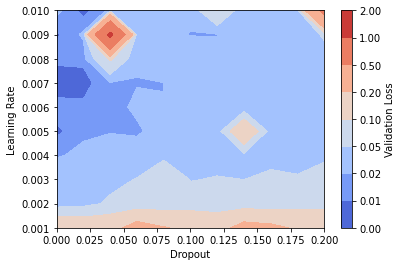

In [132]:
levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
cmap = cm.coolwarm
plt.contourf(D,L, val.T - val.min(), levels = levels,
             cmap = nlcmap(cmap, levels))
plt.colorbar(label = 'Validation Loss')
plt.xlabel('Dropout')
plt.ylabel('Learning Rate')

In [129]:
np.where(val <= val.min() + .01)

(array([0, 0, 0, 1, 1]), array([4, 6, 8, 6, 9]))

## Lyapunov Spectrum

In [55]:
D,L = np.meshgrid(dos, lrs)
model_dir = top_directory+'/HP/Models'
hp_epoch = 4 #Select which epoch (must already be trained) that you would like to calculate the Lyapunov Spectrum for
for do, lr in zip(D.flatten(), L.flatten()):
    con = Config(model_dir = model_dir, data_dir = model_dir, hidden_size = 512, 
                    dropout = do, learning_rate= lr, max_epochs = max_epochs, batch_size = 100)
    net = CharRNN(con.num_layers, vocab_size, con.hidden_size, model=con.rnn_model, p_drop = con.dropout, embedded = None)
    net.load_state_dict(torch.load(path.join(con.model_dir, con.full_name)+'_e{}.pth'.format(max_epochs)))
    con.batch_size = 10
    LEs = le_cal(net, con, dynamics = False)
    pkl.dump(LEs, open(path.join(con.model_dir, con.full_name+'_e{}_LEStats.p'.format(con.hp_epoch)), 'wb'))

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]
/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


## Metric Calculation (on LE spectrum)

### Threshold & Slope Metrics

In [6]:
def best_fit_slope(x,y):
#     m = np.mean(ys)
    xs = torch.Tensor(x)
    ys = torch.Tensor(y)
    m = (((torch.mean(xs)*torch.mean(ys)) - torch.mean(xs*ys)) /
         ((torch.mean(xs)**2) - torch.mean(xs**2)))
    return m

In [0]:
D, L = np.meshgrid(dos,lrs)
LE_means = []

max_epochs = 4
for do, lr in zip(D.flatten(), L.flatten()):
    con = Config(model_dir = model_dir, data_dir = model_dir, hidden_size = 512, 
                    dropout = do, learning_rate= lr, max_epochs = max_epochs, batch_size = 100)
    LE_stats = pkl.load(open(path.join(con.model_dir, con.full_name+'_e{}_LEStats.p'.format(con.max_epochs)), 'rb'))
    LE_means.append(LE_stats[0])
# LE_means = np.array(LE_means)

In [0]:
thresh_val = -3
slope_inds = [50,100]
slopes = []
thresh = []
for LE_mean in LE_means:
    thresh.append(sum(np.array(LE_mean>thresh_val, dtype = int)))
    slopes.append(best_fit_slope(np.array(range(slope_inds[0], slope_inds[1])), np.array(LE_mean[slope_inds[0]:slope_inds[1]])))
thresh = np.array(thresh)
slopes = np.array(slopes)

In [0]:
val = np.zeros((len(dos), len(lrs)))
for i, do in enumerate(dos):
    for j, lr in enumerate(lrs):
        con = Config(top_directory+'/HP', hidden_size = 512, dropout = do, learning_rate = lr, max_epochs = max_epochs, init_type = 'uniform',
                 init_param = 0.08)
        val_loss = pkl.load(open('{}/{}_valLossFull.p'.format(con.model_dir, con.full_name),'rb'))
        val[i,j] = val_loss[-1]

In [7]:
plt.scatter(slopes, val.flatten())

NameError: name 'thresh' is not defined

# Generate Plots

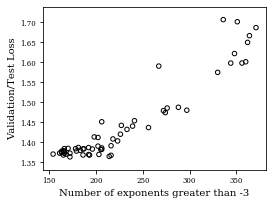

In [0]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(thresh3, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Number of exponents greater than -3')
ax.set_ylabel('Validation/Test Loss')
plt.savefig("Thresh_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

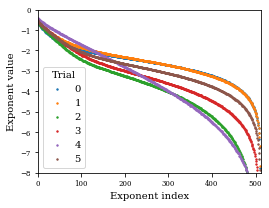

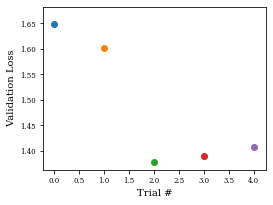

In [0]:
plt.figure(figsize = (4,3))
for idx in range(6):
    plt.scatter(range(0,512), LE_means[idx], s = 2, label = idx)
# plt.plot([0, 512], [0, 0], 'k--')
# plt.title('Lyapunov spectra of LSTM')
plt.ylabel('Exponent value')
plt.xlabel('Exponent index')
plt.ylim([-8, 0])
plt.xlim([0, 512])
plt.legend(title = 'Trial')
plt.savefig("Trial Spectra.png",bbox_inches="tight",dpi=400, format = 'png')

plt.figure(figsize = (4,3))
for i in range(5):
    plt.scatter(i, val_losses[i])
plt.xlabel('Trial #')
plt.ylabel('Validation Loss')
plt.savefig("Trial Validation Loss.png",bbox_inches="tight",dpi=400, format = 'png')

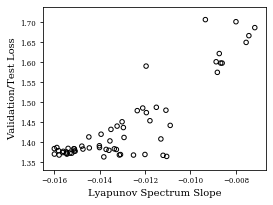

In [0]:
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(slopes, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Lyapunov Spectrum Slope')
ax.set_ylabel('Validation/Test Loss')
ax.set_xlim([min(slopes) - .0005, max(slopes) + .0005])
plt.savefig("Slopes_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

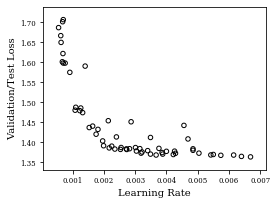

In [0]:
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(1, 1, 1)
plt.scatter(lrs, val_losses, s= 20, edgecolors = 'k', facecolors = 'none')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation/Test Loss')
ax.set_xlim([min(lrs) - .0005, max(lrs) + .0005])
# ax.set_xscale('log')
plt.savefig("LR_ValPlot.png",bbox_inches="tight",dpi=400, format = 'png')
# ax.set_title('Threshold of 3 vs Validation/Test loss')

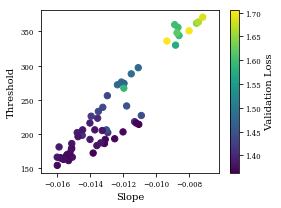

In [0]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(111)#, projection = '2d')
plt.scatter(slopes, thresh3, s = 40, c = val_losses)
# ax.set_xlabel('Slope')
# ax.set_ylabel('Threshold')
# ax.set_xlim([min(slopes)-.001, max(slopes)+.001])
plt.xlabel('Slope')
plt.ylabel('Threshold')
plt.xlim([min(slopes)-.001, max(slopes)+.001])
cbar = plt.colorbar()
cbar.set_label("Validation Loss")
# ax.set_zlabel('Validation Loss')
# ax.view_init(90, 90)

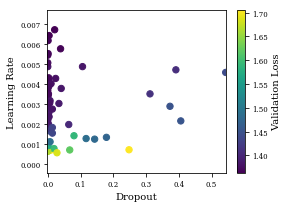

In [0]:
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 'x-small')
plt.rc('ytick', labelsize = 'x-small')
fig = plt.figure(figsize = (4,3))

ax = fig.add_subplot(111)#, projection = '2d')
plt.scatter(dos, lrs, s = 40, c = val_losses)
# ax.set_xlabel('Slope')
# ax.set_ylabel('Threshold')
# ax.set_xlim([min(slopes)-.001, max(slopes)+.001])
plt.xlabel('Dropout')
plt.ylabel('Learning Rate')
plt.xlim([min(dos)-.001, max(dos)+.001])
plt.ylim([min(lrs)-.001, max(lrs)+.001])
cbar = plt.colorbar()
cbar.set_label("Validation Loss")
# ax.set_zlabel('Validation Loss')
# ax.view_init(90, 90)